<a href="https://colab.research.google.com/github/IanEdington/learn/blob/master/machine-learning/ggl-mlcc/intro_to_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [2]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [0]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [4]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [5]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
173,-1,65,toyota,gas,std,four,sedan,fwd,front,102.40,175.60,66.50,54.90,2326,ohc,four,122,mpfi,3.31,3.54,8.70,92,4200,29,34,8948
183,2,122,volkswagen,gas,std,two,sedan,fwd,front,97.30,171.70,65.50,55.70,2209,ohc,four,109,mpfi,3.19,3.40,9.00,85,5250,27,34,7975
137,2,104,saab,gas,turbo,four,sedan,fwd,front,99.10,186.60,66.50,56.10,2847,dohc,four,121,mpfi,3.54,3.07,9.00,160,5500,19,26,18620


c:  symboling  		 type:  <class 'numpy.int64'>
c:  normalized-losses  		 type:  <class 'str'>
c:  make  		 type:  <class 'str'>
c:  fuel-type  		 type:  <class 'str'>
c:  aspiration  		 type:  <class 'str'>
c:  num-doors  		 type:  <class 'str'>
c:  body-style  		 type:  <class 'str'>
c:  drive-wheels  		 type:  <class 'str'>
c:  engine-location  		 type:  <class 'str'>
c:  wheel-base  		 type:  <class 'numpy.float64'>
c:  length  		 type:  <class 'numpy.float64'>
c:  width  		 type:  <class 'numpy.float64'>
c:  height  		 type:  <class 'numpy.float64'>
c:  weight  		 type:  <class 'numpy.int64'>
c:  engine-type  		 type:  <class 'str'>
c:  num-cylinders  		 type:  <class 'str'>
c:  engine-size  		 type:  <class 'numpy.int64'>
c:  fuel-system  		 type:  <class 'str'>
c:  bore  		 type:  <class 'str'>
c:  stroke  		 type:  <class 'str'>
c:  compression-ratio  		 type:  <class 'numpy.float64'>
c:  horsepower  		 type:  <class 'str'>
c:  peak-rpm  		 type:  <class 'str'>
c:  city-mpg  		 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac898d70b8>,
      dtype=object)

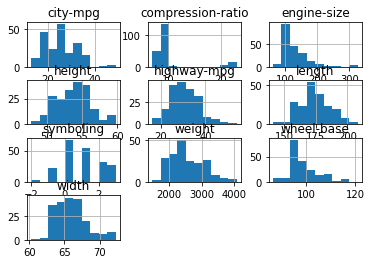

In [6]:
for c in car_data.columns:
  print("c: ", c, " \t\t type: ", type(car_data[c][1]))
car_data.hist()

In [0]:
numeric_feature_names = []
categorical_feature_names = []

In [0]:
def look_at_feature(feature):
  feature.hist()
  print(feature.head())
  print(feature.tail())
  return feature.describe()

In [9]:
for c in car_data.columns:
  print(f"look_at_feature(car_data[\"{c}\"])")

look_at_feature(car_data["symboling"])
look_at_feature(car_data["normalized-losses"])
look_at_feature(car_data["make"])
look_at_feature(car_data["fuel-type"])
look_at_feature(car_data["aspiration"])
look_at_feature(car_data["num-doors"])
look_at_feature(car_data["body-style"])
look_at_feature(car_data["drive-wheels"])
look_at_feature(car_data["engine-location"])
look_at_feature(car_data["wheel-base"])
look_at_feature(car_data["length"])
look_at_feature(car_data["width"])
look_at_feature(car_data["height"])
look_at_feature(car_data["weight"])
look_at_feature(car_data["engine-type"])
look_at_feature(car_data["num-cylinders"])
look_at_feature(car_data["engine-size"])
look_at_feature(car_data["fuel-system"])
look_at_feature(car_data["bore"])
look_at_feature(car_data["stroke"])
look_at_feature(car_data["compression-ratio"])
look_at_feature(car_data["horsepower"])
look_at_feature(car_data["peak-rpm"])
look_at_feature(car_data["city-mpg"])
look_at_feature(car_data["highway-mpg"])
look_at_feat

201   -1
55     3
46     2
126    3
173   -1
Name: symboling, dtype: int64
70    -1
102    0
26     1
7      1
68    -1
Name: symboling, dtype: int64


count   205.00
mean      0.83
std       1.25
min      -2.00
25%       0.00
50%       1.00
75%       2.00
max       3.00
Name: symboling, dtype: float64

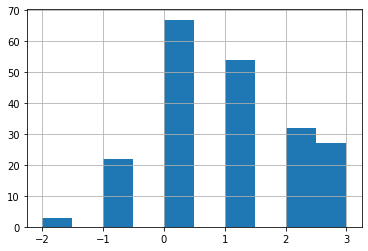

In [10]:
numeric_feature_names.append("symboling")
look_at_feature(car_data["symboling"])

201     95
55     150
46       ?
126      ?
173     65
Name: normalized-losses, dtype: object
70      93
102    108
26     148
7        ?
68      93
Name: normalized-losses, dtype: object


count     205
unique     52
top         ?
freq       41
Name: normalized-losses, dtype: object

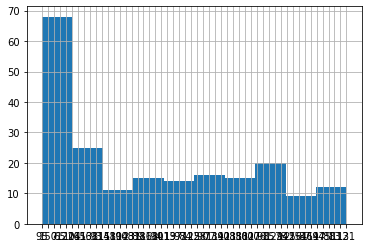

In [11]:
numeric_feature_names.append("normalized-losses")
look_at_feature(car_data["normalized-losses"])

201      volvo
55       mazda
46       isuzu
126    porsche
173     toyota
Name: make, dtype: object
70     mercedes-benz
102           nissan
26             dodge
7               audi
68     mercedes-benz
Name: make, dtype: object


count        205
unique        22
top       toyota
freq          32
Name: make, dtype: object

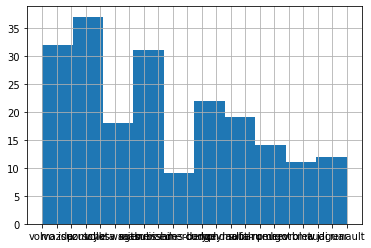

In [12]:
categorical_feature_names.append("make")
look_at_feature(car_data["make"])


201    gas
55     gas
46     gas
126    gas
173    gas
Name: fuel-type, dtype: object
70     diesel
102       gas
26        gas
7         gas
68     diesel
Name: fuel-type, dtype: object


count     205
unique      2
top       gas
freq      185
Name: fuel-type, dtype: object

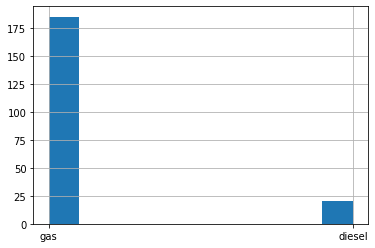

In [13]:
categorical_feature_names.append("fuel-type")

look_at_feature(car_data["fuel-type"])


201    turbo
55       std
46       std
126      std
173      std
Name: aspiration, dtype: object
70     turbo
102      std
26       std
7        std
68     turbo
Name: aspiration, dtype: object


count     205
unique      2
top       std
freq      168
Name: aspiration, dtype: object

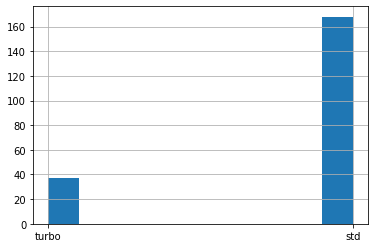

In [14]:
categorical_feature_names.append("aspiration")

look_at_feature(car_data["aspiration"])


201    four
55      two
46      two
126     two
173    four
Name: num-doors, dtype: object
70     four
102    four
26     four
7      four
68     four
Name: num-doors, dtype: object


count      205
unique       3
top       four
freq       114
Name: num-doors, dtype: object

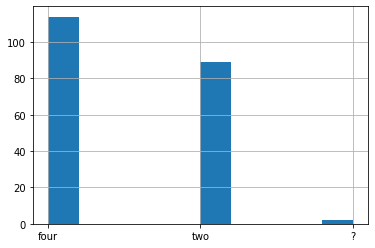

In [15]:
categorical_feature_names.append("num-doors")

look_at_feature(car_data["num-doors"])


201        sedan
55     hatchback
46     hatchback
126      hardtop
173        sedan
Name: body-style, dtype: object
70     sedan
102    wagon
26     sedan
7      wagon
68     wagon
Name: body-style, dtype: object


count       205
unique        5
top       sedan
freq         96
Name: body-style, dtype: object

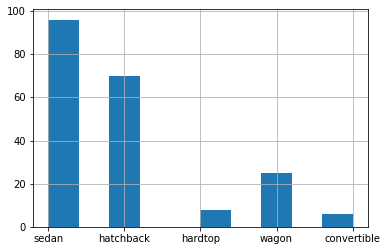

In [16]:
categorical_feature_names.append("body-style")
look_at_feature(car_data["body-style"])


201    rwd
55     rwd
46     rwd
126    rwd
173    fwd
Name: drive-wheels, dtype: object
70     rwd
102    fwd
26     fwd
7      fwd
68     rwd
Name: drive-wheels, dtype: object


count     205
unique      3
top       fwd
freq      120
Name: drive-wheels, dtype: object

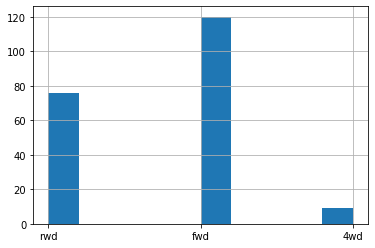

In [17]:
categorical_feature_names.append("drive-wheels")

look_at_feature(car_data["drive-wheels"])


201    front
55     front
46     front
126     rear
173    front
Name: engine-location, dtype: object
70     front
102    front
26     front
7      front
68     front
Name: engine-location, dtype: object


count       205
unique        2
top       front
freq        202
Name: engine-location, dtype: object

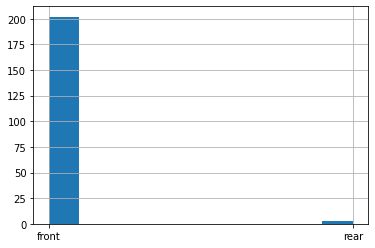

In [18]:
categorical_feature_names.append("engine-locations")

look_at_feature(car_data["engine-location"])


201   109.10
55     95.30
46     96.00
126    89.50
173   102.40
Name: wheel-base, dtype: float64
70    115.60
102   100.40
26     93.70
7     105.80
68    110.00
Name: wheel-base, dtype: float64


count   205.00
mean     98.76
std       6.02
min      86.60
25%      94.50
50%      97.00
75%     102.40
max     120.90
Name: wheel-base, dtype: float64

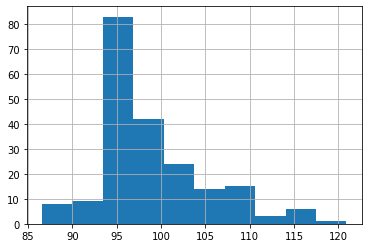

In [19]:

numeric_feature_names.append("wheel-bases")
look_at_feature(car_data["wheel-base"])


201   188.80
55    169.00
46    172.60
126   168.90
173   175.60
Name: length, dtype: float64
70    202.60
102   184.60
26    157.30
7     192.70
68    190.90
Name: length, dtype: float64


count   205.00
mean    174.05
std      12.34
min     141.10
25%     166.30
50%     173.20
75%     183.10
max     208.10
Name: length, dtype: float64

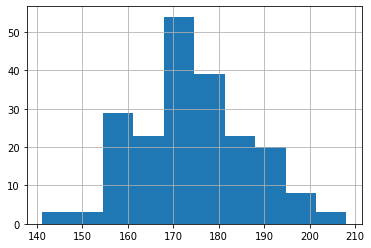

In [20]:

numeric_feature_names.append("length")
look_at_feature(car_data["length"])


201   68.80
55    65.70
46    65.20
126   65.00
173   66.50
Name: width, dtype: float64
70    71.70
102   66.50
26    63.80
7     71.40
68    70.30
Name: width, dtype: float64


count   205.00
mean     65.91
std       2.15
min      60.30
25%      64.10
50%      65.50
75%      66.90
max      72.30
Name: width, dtype: float64

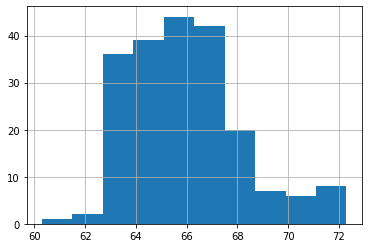

In [21]:

numeric_feature_names.append("width")
look_at_feature(car_data["width"])


201   55.50
55    49.60
46    51.40
126   51.60
173   54.90
Name: height, dtype: float64
70    56.30
102   56.10
26    50.60
7     55.70
68    58.70
Name: height, dtype: float64


count   205.00
mean     53.72
std       2.44
min      47.80
25%      52.00
50%      54.10
75%      55.50
max      59.80
Name: height, dtype: float64

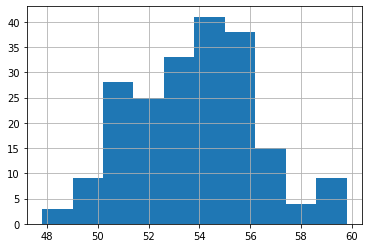

In [22]:

numeric_feature_names.append("height")
look_at_feature(car_data["height"])


201    3049
55     2380
46     2734
126    2756
173    2326
Name: weight, dtype: int64
70     3770
102    3296
26     1989
7      2954
68     3750
Name: weight, dtype: int64


count    205.00
mean    2555.57
std      520.68
min     1488.00
25%     2145.00
50%     2414.00
75%     2935.00
max     4066.00
Name: weight, dtype: float64

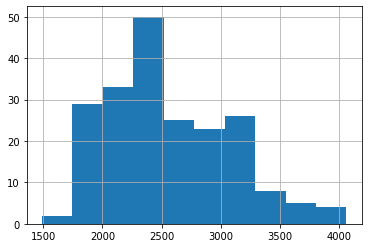

In [23]:

numeric_feature_names.append("weight")
look_at_feature(car_data["weight"])


201      ohc
55     rotor
46       ohc
126     ohcf
173      ohc
Name: engine-type, dtype: object
70      ohc
102    ohcv
26      ohc
7       ohc
68      ohc
Name: engine-type, dtype: object


count     205
unique      7
top       ohc
freq      148
Name: engine-type, dtype: object

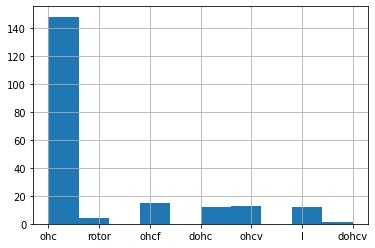

In [24]:

categorical_feature_names.append("engine-type")
look_at_feature(car_data["engine-type"])


201    four
55      two
46     four
126     six
173    four
Name: num-cylinders, dtype: object
70     five
102     six
26     four
7      five
68     five
Name: num-cylinders, dtype: object


count      205
unique       7
top       four
freq       159
Name: num-cylinders, dtype: object

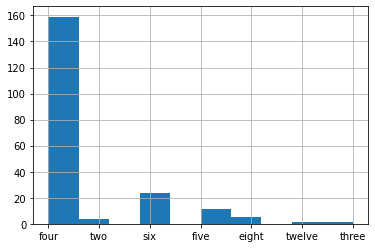

In [25]:

categorical_feature_names.append("num-cylinders")
look_at_feature(car_data["num-cylinders"])


201    141
55      70
46     119
126    194
173    122
Name: engine-size, dtype: int64
70     183
102    181
26      90
7      136
68     183
Name: engine-size, dtype: int64


count   205.00
mean    126.91
std      41.64
min      61.00
25%      97.00
50%     120.00
75%     141.00
max     326.00
Name: engine-size, dtype: float64

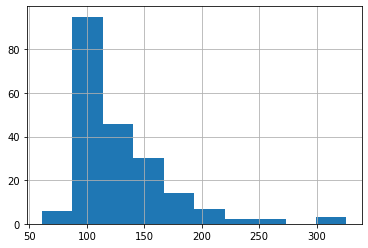

In [26]:

numeric_feature_names.append("engine-size")
look_at_feature(car_data["engine-size"])


201    mpfi
55     4bbl
46     spfi
126    mpfi
173    mpfi
Name: fuel-system, dtype: object
70      idi
102    mpfi
26     2bbl
7      mpfi
68      idi
Name: fuel-system, dtype: object


count      205
unique       8
top       mpfi
freq        94
Name: fuel-system, dtype: object

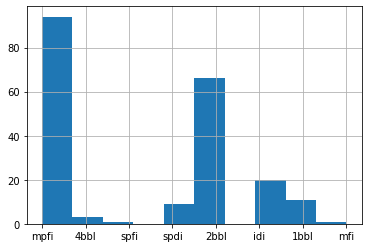

In [27]:

categorical_feature_names.append("fuel-system")
look_at_feature(car_data["fuel-system"])


201    3.78
55        ?
46     3.43
126    3.74
173    3.31
Name: bore, dtype: object
70     3.58
102    3.43
26     2.97
7      3.19
68     3.58
Name: bore, dtype: object


count      205
unique      39
top       3.62
freq        23
Name: bore, dtype: object

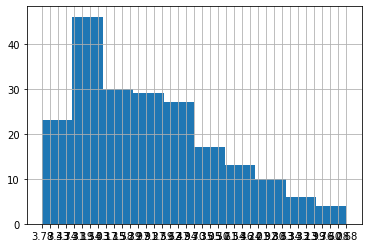

In [28]:

numeric_feature_names.append("bore")
look_at_feature(car_data["bore"])


201    3.15
55        ?
46     3.23
126    2.90
173    3.54
Name: stroke, dtype: object
70     3.64
102    3.27
26     3.23
7      3.40
68     3.64
Name: stroke, dtype: object


count      205
unique      37
top       3.40
freq        20
Name: stroke, dtype: object

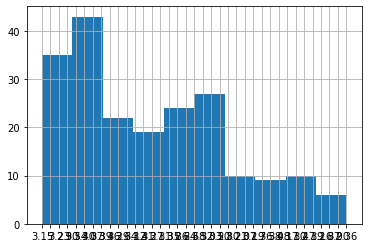

In [29]:

numeric_feature_names.append("stroke")
look_at_feature(car_data["stroke"])


201   8.70
55    9.40
46    9.20
126   9.50
173   8.70
Name: compression-ratio, dtype: float64
70    21.50
102    9.00
26     9.40
7      8.50
68    21.50
Name: compression-ratio, dtype: float64


count   205.00
mean     10.14
std       3.97
min       7.00
25%       8.60
50%       9.00
75%       9.40
max      23.00
Name: compression-ratio, dtype: float64

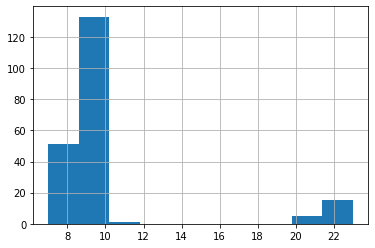

In [30]:

numeric_feature_names.append("compression-ratio")
look_at_feature(car_data["compression-ratio"])


201    160
55     101
46      90
126    207
173     92
Name: horsepower, dtype: object
70     123
102    152
26      68
7      110
68     123
Name: horsepower, dtype: object


count     205
unique     60
top        68
freq       19
Name: horsepower, dtype: object

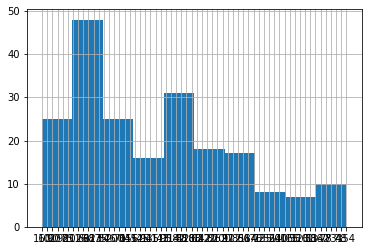

In [31]:

numeric_feature_names.append("horsepower")
look_at_feature(car_data["horsepower"])


201    5300
55     6000
46     5000
126    5900
173    4200
Name: peak-rpm, dtype: object
70     4350
102    5200
26     5500
7      5500
68     4350
Name: peak-rpm, dtype: object


count      205
unique      24
top       5500
freq        37
Name: peak-rpm, dtype: object

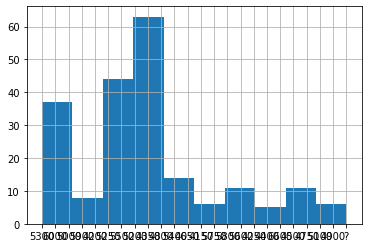

In [32]:

numeric_feature_names.append("peak-rpm")
look_at_feature(car_data["peak-rpm"])


201    19
55     17
46     24
126    17
173    29
Name: city-mpg, dtype: int64
70     22
102    17
26     31
7      19
68     22
Name: city-mpg, dtype: int64


count   205.00
mean     25.22
std       6.54
min      13.00
25%      19.00
50%      24.00
75%      30.00
max      49.00
Name: city-mpg, dtype: float64

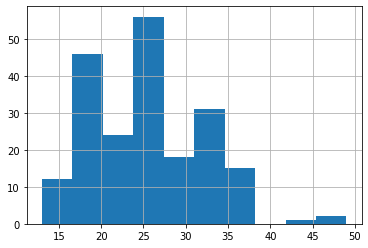

In [33]:

numeric_feature_names.append("city-mpg")
look_at_feature(car_data["city-mpg"])

201    25
55     23
46     29
126    25
173    34
Name: highway-mpg, dtype: int64
70     25
102    22
26     38
7      25
68     25
Name: highway-mpg, dtype: int64


count   205.00
mean     30.75
std       6.89
min      16.00
25%      25.00
50%      30.00
75%      34.00
max      54.00
Name: highway-mpg, dtype: float64

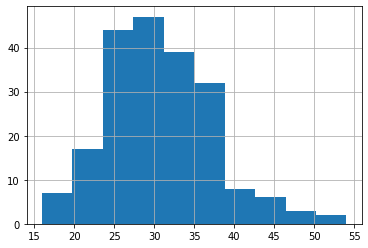

In [34]:
numeric_feature_names.append("highway-mpg")
look_at_feature(car_data["highway-mpg"])


In [35]:
print(numeric_feature_names)
print(len(numeric_feature_names))
print(categorical_feature_names)
print(len(categorical_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

['symboling', 'normalized-losses', 'wheel-bases', 'length', 'width', 'height', 'weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
15
['make', 'fuel-type', 'aspiration', 'num-doors', 'body-style', 'drive-wheels', 'engine-locations', 'engine-type', 'num-cylinders', 'fuel-system']
10


In [0]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
LABEL = "price"
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [39]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
201,-1,95,109.10,188.80,68.80,55.50,3049,141,160,5300,19,25,3.78,3.15,8.70
55,3,150,95.30,169.00,65.70,49.60,2380,70,101,6000,17,23,?,?,9.40
46,2,?,96.00,172.60,65.20,51.40,2734,119,90,5000,24,29,3.43,3.23,9.20
126,3,?,89.50,168.90,65.00,51.60,2756,194,207,5900,17,25,3.74,2.90,9.50
173,-1,65,102.40,175.60,66.50,54.90,2326,122,92,4200,29,34,3.31,3.54,8.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-1,93,115.60,202.60,71.70,56.30,3770,183,123,4350,22,25,3.58,3.64,21.50
102,0,108,100.40,184.60,66.50,56.10,3296,181,152,5200,17,22,3.43,3.27,9.00
26,1,148,93.70,157.30,63.80,50.60,1989,90,68,5500,31,38,2.97,3.23,9.40
7,1,?,105.80,192.70,71.40,55.70,2954,136,110,5500,19,25,3.19,3.40,8.50


In [40]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,num-doors,engine-location,body-style,fuel-system,drive-wheels,engine-type,aspiration,fuel-type,make,num-cylinders
201,four,front,sedan,mpfi,rwd,ohc,turbo,gas,volvo,four
55,two,front,hatchback,4bbl,rwd,rotor,std,gas,mazda,two
46,two,front,hatchback,spfi,rwd,ohc,std,gas,isuzu,four
126,two,rear,hardtop,mpfi,rwd,ohcf,std,gas,porsche,six
173,four,front,sedan,mpfi,fwd,ohc,std,gas,toyota,four
...,...,...,...,...,...,...,...,...,...,...
70,four,front,sedan,idi,rwd,ohc,turbo,diesel,mercedes-benz,five
102,four,front,wagon,mpfi,fwd,ohcv,std,gas,nissan,six
26,four,front,sedan,2bbl,fwd,ohc,std,gas,dodge,four
7,four,front,wagon,mpfi,fwd,ohc,std,gas,audi,five


In [0]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [49]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

In [50]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpa8arrbdq/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


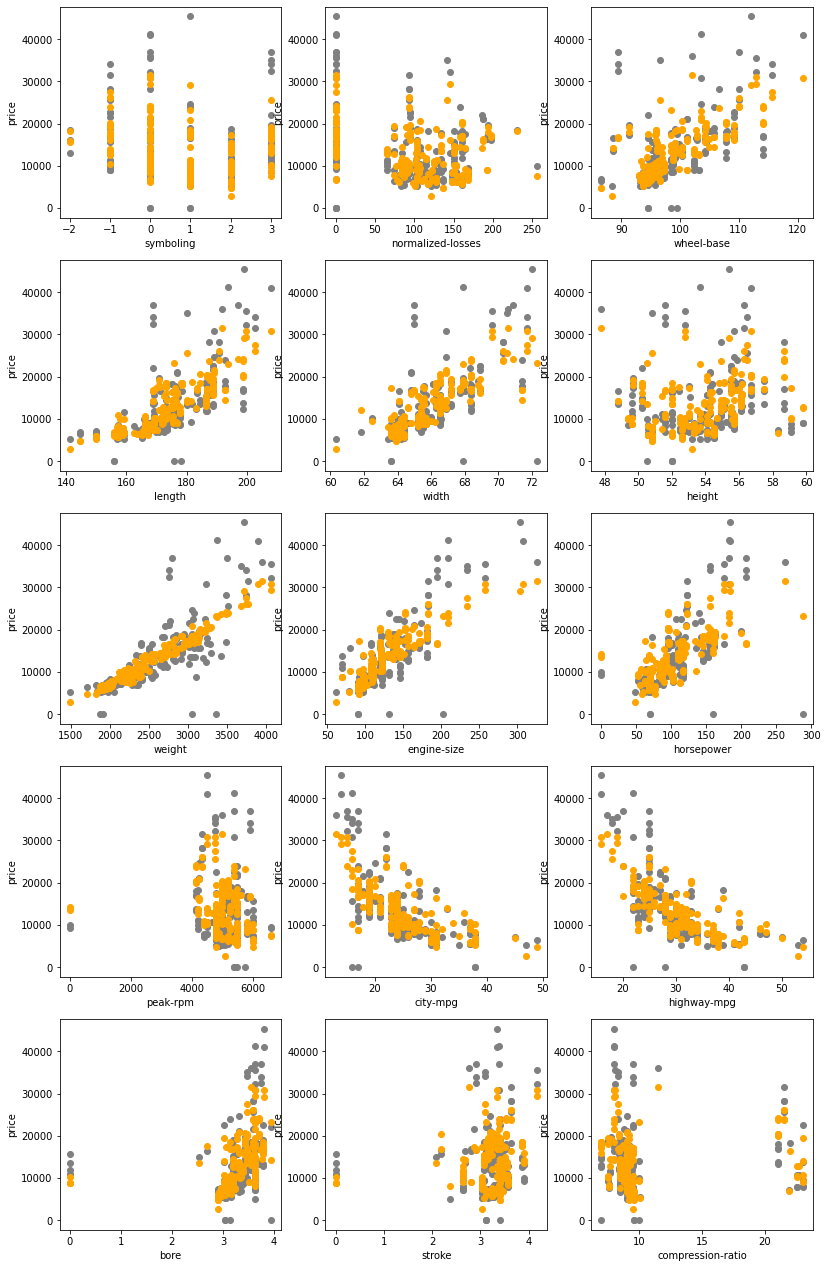

In [51]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

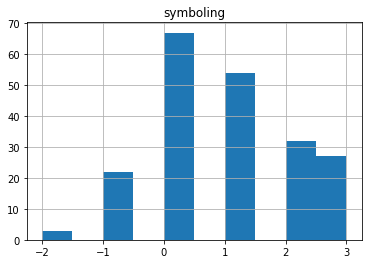

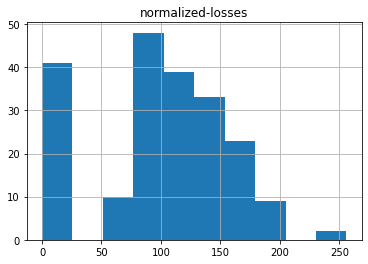

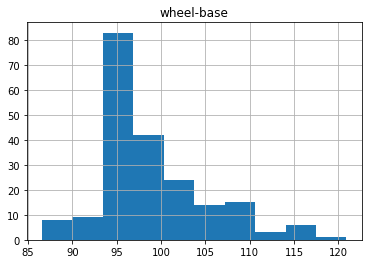

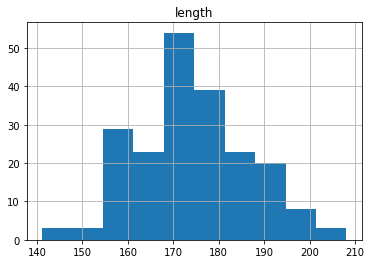

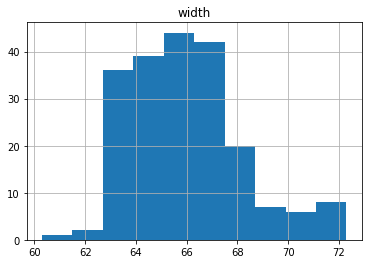

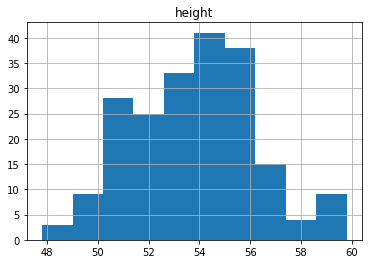

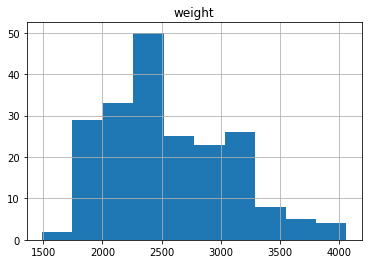

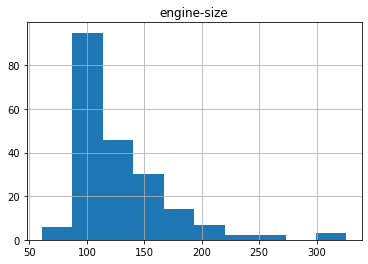

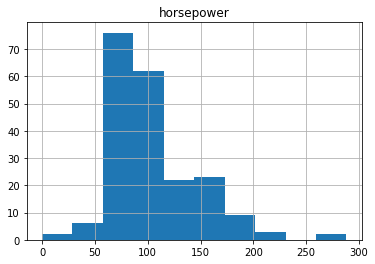

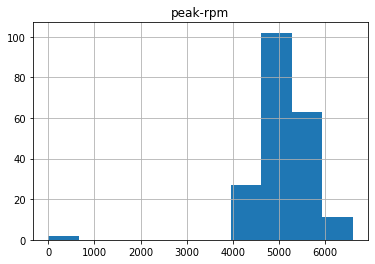

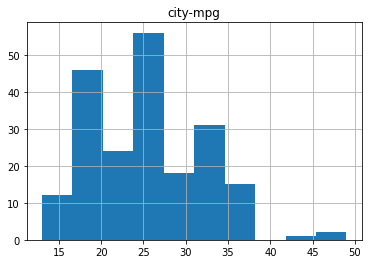

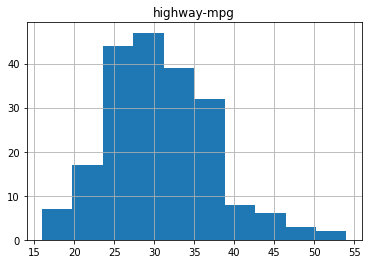

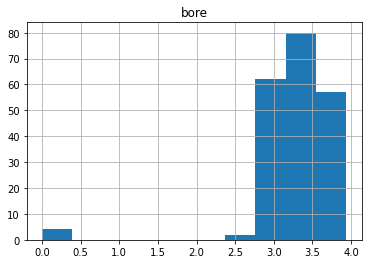

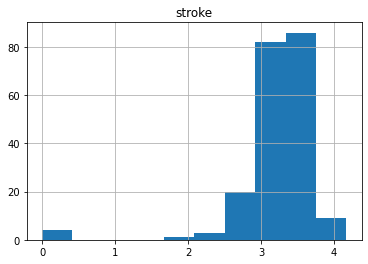

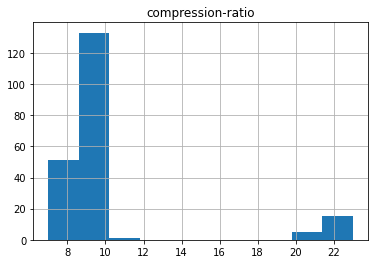

In [52]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [0]:
## Your code goes here

In [0]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [0]:
## Your code goes here

In [0]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [0]:
## Your code goes here

In [0]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

